In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.random import rand, randn
from scipy.misc import imsave
from mpl_toolkits.mplot3d import Axes3D

# SA(2) invariant signatures
We are considering transformations in $SA(2)$ of the following form:

\begin{equation}
   \hat{x}_i = a_{ij} x_j + b_i
\end{equation}

where $\det a = 1$, or in vector notation $\hat{x} = Ax + b$, $\det A = 1$. Our image $f : \mathbb{R}^2 \mapsto \mathbb{R}$ transforms as $f(x) = \hat{f}(\hat{x})$. Then, we have the following:

\begin{align}
    f_{,i} &= \hat{f}_{,k}a_{ki}, & \nabla{f} &= A^T \nabla{\hat{f}} \\
    f_{,ij} &= \hat{f}_{,kl} a_{ki} a_{lj} & \nabla^2 f &= A^T \nabla^2 \hat{f} A
\end{align}

We can see that in vector notation, we have the following invariants under SA(2) (at $x$ on the left and $\hat{x}$ on the right:
1. $I_0 = f(x) = \hat{f}(\hat{x})$
2. $I_1 = \det \nabla^2 f(x) = \det(A^T)\det \nabla^2 \hat{f} \det(A) = \det \nabla^2 \hat{f}$
3. $I_2 =(\nabla f)^T (\nabla^2 f)^{-1} (\nabla f) = (\nabla \hat{f})^T A A^{-1} (\nabla^2 \hat{f})^{-1} A^{-T} A^T \nabla{\hat f} = (\nabla \hat{f})^T (\nabla^2 \hat{f})^{-1} \nabla \hat{f}$

The third invariant is in fact invariant under $A(2)$, not just $SA(2)$. However, for $SA(2)$ we can replace it with a polynomial by multiplying by $\det \nabla^2 f$, in which case $(\nabla^2 f)^{-1}$ is replaced by $\text{adj} \nabla^2 f$.

3a. $I_2 = (\nabla f)^T \text{adj} \nabla^2 f \nabla f = f_{yy} f_x^2 - 2f_{xy}f_x f_y + f_{xx} f_y^2 $

## Update: transvectants
Let's also check to see whether Robert's transvectant formulae also work (the first two being ones we already know):
1. $f_{xx} f_{yy} - f_{xy}^2$
2. $f_y^2 f_{xx} - 2f_x f_y f_{xy} + f_x^2 f_{yy}$
3. $f_{yy} f_{xxy}^2 - f_{yy} f_{xxx} f_{xyy} - f_{xy} f_{xxy} f_{xyy} + f_{xx} f_{xyy}^2 + f_{xy} f_{xxx} f_{yyy} - f_{xx} f_{xxy} f_{yyy}$
4. $f_y f_{yy} f_{xxx} - 2f_y f_{xy} f_{xxy} - f_x f_{yy} f_{xxy} + f_y  f_{xx} f_{xyy} + 2f_x f_{xy} f_{xyy} - f_x  f_{xx} f_{yyy}$

In [8]:
def SA2signature(F, h=1):
    """ All the degree three and lower transvectants"""
    Fx, Fy = np.gradient(F, h)
    Fxx, Fxy = np.gradient(Fx, h)
    Fyx, Fyy = np.gradient(Fy, h)
    Fxxx, Fxxy = np.gradient(Fxx, h)
    Fxyx, Fxyy = np.gradient(Fxy, h)
    Fyyx, Fyyy = np.gradient(Fyy, h)
    
    I0 = F
    I1 = Fxx*Fyy - Fxy**2
    I2 = Fy**2*Fxx - 2*Fx*Fy*Fxy + Fx**2*Fyy
    I3 = Fyy*Fxxy**2 - Fyy*Fxxx*Fxyy - Fxy*Fxxy*Fxyy + Fxx*Fxyy**2 + Fxy*Fxxx*Fyyy - Fxx*Fxxy*Fyyy
    I4 = Fy*Fyy*Fxxx - 2*Fy*Fxy*Fxxy - Fx*Fyy*Fxxy + Fy*Fxx*Fxyy + 2*Fx*Fxy*Fxyy - Fx*Fxx*Fyyy
    
    return (I0, I1, I2, I3, I4)

def SE2signature(F, h=1):
    """ Compute equiaffine-invariant image signature using finite differences"""
    Fx, Fy = np.gradient(F, h)
    Fxx, Fxy = np.gradient(Fx, h)
    Fyx, Fyy = np.gradient(Fy, h)
    
    I0 = F # function value
    I1 = Fx*Fx + Fy*Fy
    I2 = Fxx + Fyy
    return (I0, I1, I2)

## Currents

The currents formulae are defined below. Currently quick and dirty, needs some spit and polish.


In [9]:
def triangle_areas(X, Y):
    
    
    lower = 0.5 * np.abs(X[0:-1, 1:] * (Y[1:, 0:-1] - Y[1:, 1:]) + 
                   X[1:, 0:-1] * (Y[1:, 1:] - Y[0:-1, 1:]) +
                   X[1:, 1:] * (Y[0:-1, 1:] - Y[1:, 0:-1]))
        
    upper = 0.5 * np.abs(X[0:-1, 0:-1] * (Y[1:, 0:-1] - Y[1:, 1:]) + 
                   X[1:, 0:-1] * (Y[1:, 1:] - Y[0:-1, 0:-1]) +
                   X[1:, 1:] * (Y[0:-1, 0:-1] - Y[1:, 0:-1]))
        
    return lower, upper

def compute_centroids(I):
    lower = 1./3. * (I[0:-1, 1:] + I[1:, 0:-1] + I[1:, 1:])
    upper = 1./3. * (I[0:-1, 0:-1] + I[0:-1, 1:] + I[1:, 0:-1])
    return lower, upper


def currents(invariants, N):
    centroids = [compute_centroids(I) for I in invariants]
    
    I0, I1, I2 = invariants[:]
    dxdy_l, dxdy_u = triangle_areas(I0, I1)
    dydz_l, dydz_u = triangle_areas(I1, I2)
    dxdz_l, dxdz_u = triangle_areas(I0, I2)
    
    C = []
    for m in range(N + 1):
        for n in range(N + 1 - m):
            for k in range(N + 1 - m - n):
                integrand_l = centroids[0][0]**m * centroids[1][0]**n * centroids[2][0]**k 
                integrand_u = centroids[0][1]**m * centroids[1][1]**n * centroids[2][1]**k
           
                C.append([m, n, k, 1, (integrand_l * dxdy_l + integrand_u * dxdy_u).sum()])
                C.append([m, n, k, 2, (integrand_l * dydz_l + integrand_u * dydz_u).sum()])
                C.append([m, n, k, 3, (integrand_l * dxdz_l + integrand_u * dxdz_u).sum()])
    xc = np.array([c[4] for c in C])
    return xc

In [7]:
triangle_areas(np.array([[0, 1],[0, 1]]), np.array([[0, 0], [1, 1]]))

(array([[ 0.5]]), array([[ 0.5]]))

# Piecewise linear current integrals (not piecewise constant)

In [61]:
def current_linear(Ax, Ay, Bx, By, Cx, Cy, Ma, Mb, Mc):
    return 1/6.0 * ((Ma + Mb + Mc) * np.abs((Bx - Ax)*(Cy - Ay) - (Cx - Ax)*(By - Ay))).sum()
    
def currents(invariants, N):
    X, Y, Z = invariants[:]
    
    lower_xy = [X[:-1, 1:], Y[:-1, 1:], X[1:, :-1],  Y[1:, :-1],  X[1:, 1:], Y[1:, 1:]]
    upper_xy = [X[1:, :-1], Y[1:, :-1], X[:-1, :-1], Y[:-1, :-1], X[1:, 1:], Y[1:, 1:]]
    lower_xz = [X[:-1, 1:], Z[:-1, 1:], X[1:, :-1],  Z[1:, :-1],  X[1:, 1:], Z[1:, 1:]]
    upper_xz = [X[1:, :-1], Z[1:, :-1], X[:-1, :-1], Z[:-1, :-1], X[1:, 1:], Z[1:, 1:]]
    lower_yz = [Y[:-1, 1:], Z[:-1, 1:], Y[1:, :-1],  Z[1:, :-1],  Y[1:, 1:], Z[1:, 1:]]
    upper_yz = [Y[1:, :-1], Z[1:, :-1], Y[:-1, :-1], Z[:-1, :-1], Y[1:, 1:], Z[1:, 1:]]
    
    C = []
    for m in range(N + 1):
        for n in range(N + 1 - m):
            for k in range(N + 1 - m - n):
                M = X**m * Y**n * Z**k
                M_lower = [M[:-1, 1:], M[1:, :-1], M[1:, 1:]]
                M_upper = [M[1:, :-1], M[:-1, :-1], M[1:, 1:]]
            
                C.append(current_linear(*(lower_xy + M_lower)) + current_linear(*(upper_xy + M_upper)))
                C.append(current_linear(*(lower_xz + M_lower)) + current_linear(*(upper_xz + M_upper)))
                C.append(current_linear(*(lower_yz + M_lower)) + current_linear(*(upper_yz + M_upper)))
                
    return C
    
    
    
    
    

In [63]:
Ax, Ay, Bx, By, Cx, Cy = np.array([0]), np.array([0]), np.array([0]), np.array([1]),np.array([1]), np.array([0])
Ma, Mb, Mc = np.array([1]), np.array([1]), np.array([1])
print 'prism: ' + str(current_linear(Ax, Ay, Bx, By, Cx, Cy, Ma, Mb, Mc))

Ax, Ay, Bx, By, Cx, Cy = np.array([0]), np.array([0]), np.array([0]), np.array([2]),np.array([2]), np.array([0])
Ma, Mb, Mc = np.array([1]), np.array([1]), np.array([1])
print 'scaled prism: ' + str(current_linear(Ax, Ay, Bx, By, Cx, Cy, Ma, Mb, Mc))

Ax, Ay, Bx, By, Cx, Cy = np.array([-0.5]), np.array([2]), np.array([-0.5]), np.array([4]),np.array([1.5]), np.array([2])
Ma, Mb, Mc = np.array([1]), np.array([1]), np.array([1])
print 'scaled shifted prism: ' + str(current_linear(Ax, Ay, Bx, By, Cx, Cy, Ma, Mb, Mc))

prism: 0.5
scaled prism: 2.0
scaled shifted prism: 2.0


## Random Transformations
We generate a random equiaffine transformation $x \mapsto Ax + b$, $\det A = 1$ using the `RandomEquiaffine` class, and we generate random noise by adding on some random trigonometric terms. The noise should be done more nicely by specifying a PSD, and then inverting the Fourier transform, but my brain was hurting. Marking this as a TODO.


In [102]:
from numpy.random import rand, randn
import numpy.random
from scipy.fftpack import ifft2, idct, dct

class RandomEquiaffine():
    def __init__(self):
        theta = 2*np.pi*np.random.rand();
        self.A =  np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]) + np.random.rand(2,2)
        if np.linalg.det(self.A) < 0:
            self.A[:, 1] = -self.A[:, 1]
        self.A = self.A / np.sqrt(np.linalg.det(self.A))
        self.b = 0.1 * randn(2)
        self.Ainv = np.linalg.inv(self.A)
        self.binv = -np.linalg.solve(self.A, self.b)
    
    def forward_transform(self, f, X, Y):
        return f(self.Ainv[0,0]*X + self.Ainv[0,1]*Y + self.binv[0], 
                 self.Ainv[1,0]*X + self.Ainv[1,1]*Y + self.binv[1])

class RandomSE2():
    def __init__(self):
        theta = 2*np.pi*np.random.rand();
        self.A =  np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        self.b = 0.1 * randn(2)
        self.Ainv = self.A.T
        self.binv = -np.linalg.solve(self.A, self.b)
    
    def forward_transform(self, f, X, Y):
        return f(self.Ainv[0,0]*X + self.Ainv[0,1]*Y + self.binv[0], 
                 self.Ainv[1,0]*X + self.Ainv[1,1]*Y + self.binv[1])


def smooth_noise(shape, width=1, decay=100):
    m, n = shape
    m_freq = np.arange(m) / m
    n_freq = np.arange(n) / n
    Mf, Nf = np.meshgrid(n_freq, m_freq)
    
    W = width*numpy.random.standard_normal(shape) * np.exp(-decay*(Mf + Nf))
    W[0,0] = 0
    
    X = idct(idct(W, axis=0), axis=1)    
    return X

    
# TODO: do this with DFT
def rand_noise(shape, var=1, n_trig=10, beta=10):
    m, n = shape
    m_freq = np.arange(m) / m
    n_freq = np.arange(n) / n
    Mf, Nf = np.meshgrid(m_freq, n_freq)
    W = np.zeros(shape)
    for i in range(n_trig):
        W = W + np.sqrt(var) / np.sqrt(n_trig) * np.cos(beta*rand()*Mf + 2*np.pi*rand()) * np.cos(beta*rand()*Nf + 2*np.pi*rand())
    return W
    

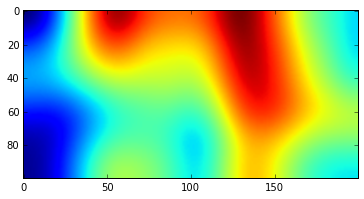

In [101]:
plt.imshow(smooth_noise((100, 200), decay=100))

# Numerical Experiment
We define two functions that look visually similar, transform them under noise, and then try to classify using currents.

In [122]:
def f(x, y):
    return 0.5*(1 + np.sin(4*x) * np.cos(7*y)) * 2*np.exp(-10*((x - 0.1)**2 + (y+0.2)**2))

def g(x, y):
    return 0.5*(1 + np.sin(5*x) * np.cos(6*y)) * 2*np.exp(-12*((x - 0.1)**2 + (y+0.2)**2))

def experiment(f, X, Y, h, width=0.0):
    t = RandomEquiaffine()
    F = t.forward_transform(f, X, Y)
    W = smooth_noise(X.shape, var=width)
    sig = SA2signature(F + W, h)
    S = [sig[0], sig[1], sig[2]]
    return {'C': currents(S, 1), 'S': S, 'F': F, 'W': W}

def experiment_SE2(f, X, Y, h, width=0.0):
    t = RandomSE2()
    F = t.forward_transform(f, X, Y)
    W = smooth_noise(X.shape, width=width)
    sig = SE2signature(F + W, h)
    S = [sig[0], sig[1], sig[2]]
    return {'C': currents(S, 3), 'S': S, 'F': F, 'W': W}

t = RandomSE2()

[64.590322319502761, 150.09299958472008, 8264.3791311138593, -818.82621204729242, -454.93403349564232, -77905.897551315953, 935.24176238812731, 1680.0056257655528, 117081.16813023787, 41.764811732263006, 70.910926704210254, 5015.3165876404182]
[64.506347940777971, 149.94002697448497, 8250.9389344527044, -814.13242323933252, -453.84996035407397, -77463.556525633874, 933.40052483068507, 1678.5388864510937, 116853.34631026797, 41.671821188147106, 70.825151018184329, 5004.2135218038957]


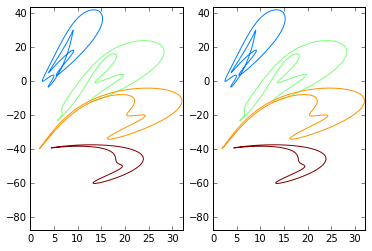

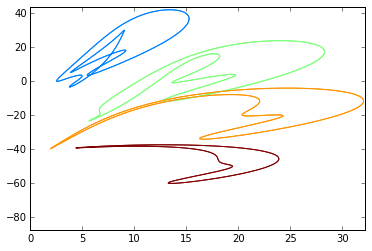

In [68]:
%matplotlib inline
def f2(x, y):
    return 0.5*np.exp(-10.0*(x - 0.1)**2 - 8.0*(y+0.2)**2)


h = 0.005
X, Y = np.meshgrid(np.arange(-1.5, 1.5, h), np.arange(-1.5, 1.5, h))

F0 = f(X, Y)
F1 = t.forward_transform(f, X, Y)
sig0 = SE2signature(F0, h)
sig1 = SE2signature(F1, h)

levels = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.subplot(1,2,1)
plt.contour(sig0[1], sig0[2], sig0[0], levels=levels, color='blue')
plt.subplot(1,2,2)
plt.contour(sig1[1], sig1[2], sig1[0], levels=levels, color='red')
plt.figure()
plt.contour(sig0[1], sig0[2], sig0[0], levels=levels, color='blue')
plt.contour(sig1[1], sig1[2], sig1[0], levels=levels, color='red')
print currents([sig0[0], sig0[1], sig0[2]], 1)
print currents([sig1[0], sig1[1], sig1[2]], 1)


In [ ]:
n_transformations = 20

width = 0.001
E1 = [experiment_SE2(f, X, Y, h, width=width) for i in range(n_transformations)]
E2 = [experiment_SE2(g, X, Y, h, width=width) for i in range(n_transformations)]

In [ ]:

plt.imshow(f(X, Y), cmap=cm.gray())

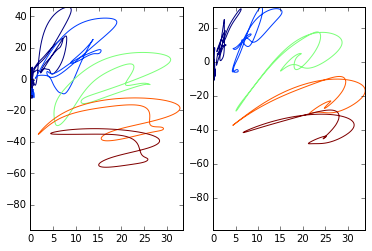

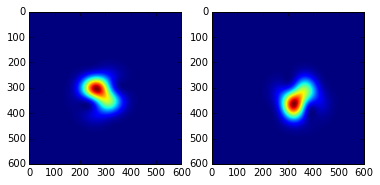

In [130]:

sig1 = E1[0]['S']
sig2 = E2[0]['S']
levels = [0.1, 0.25, 0.5, 0.75, 0.9]
plt.subplot(1,2,1)
plt.contour(sig1[1], sig1[2], sig1[0], levels=levels )
plt.subplot(1,2,2)
plt.contour(sig2[1], sig2[2], sig2[0], levels=levels )

plt.figure()
plt.subplot(1,2,1)
plt.imshow(E1[0]['F'])
plt.subplot(1,2,2)
plt.imshow(E1[1]['F'])

## Compare signatures of the two images
We compare the signatures for a few contours (with respect to the function value)


In [ ]:
C = np.array([e['C'] for e in E1] + [e['C'] for e in E2])
C = C - np.mean(C, axis=0)
from scipy.linalg import svd
U, S, Vh = svd(C)
print S[0:5]
smeg = C.dot(Vh[0:2, :].T)
plt.clf()
plt.scatter(smeg[0:n_transformations,0], smeg[0:n_transformations,1], color='red')
plt.scatter(smeg[n_transformations:,0], smeg[n_transformations:,1], color='blue')

In [ ]:
plt.imshow(f(X, Y), cmap=cm.gray)
imsave('f.jpg', f(X, Y))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sig = SE2signature(f(X, Y), h)
ax.plot_surface(sig[1], sig[2], sig[0], rstride=10, cstride=10)
plt.show()
